# Import data

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# EDA

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
!pip install catppuccin
import catppuccin

# Set the Catppuccin style (Mocha palette)
mpl.style.use(["ggplot", catppuccin.PALETTE.latte.identifier])

def pie (category):
    # Aggregate the data by counting occurrences of each category
    category_counts = train_data[category].value_counts()

    # Plotting the pie chart
    plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(category)
    plt.show()
    
def hist (category, nbins):
    plt.hist(train_data[category], bins=nbins)
    plt.title(category)
    plt.xlabel(category)
    plt.ylabel('Frequency')
    plt.show()

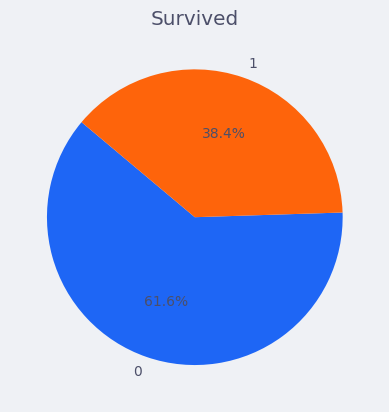

In [5]:
pie('Survived')

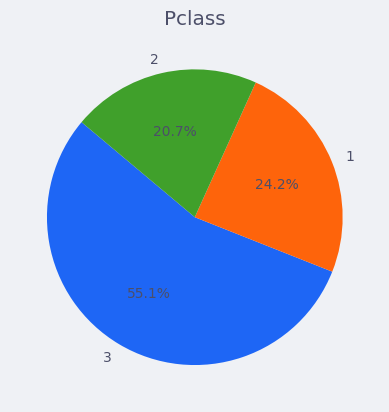

In [6]:
pie('Pclass')

Pclass is a categorical variable

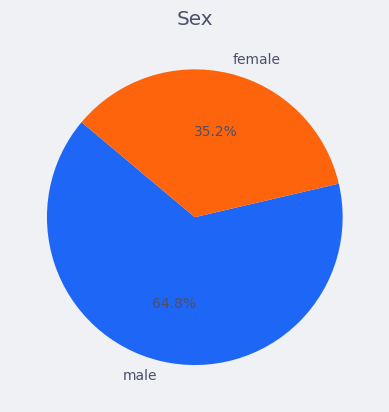

In [7]:
pie('Sex')

Sex is a categorical variable

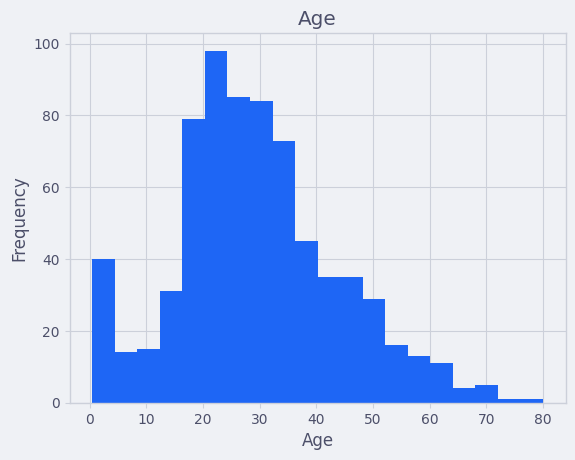

In [8]:
hist ('Age', 20)

Age is a continuous variable

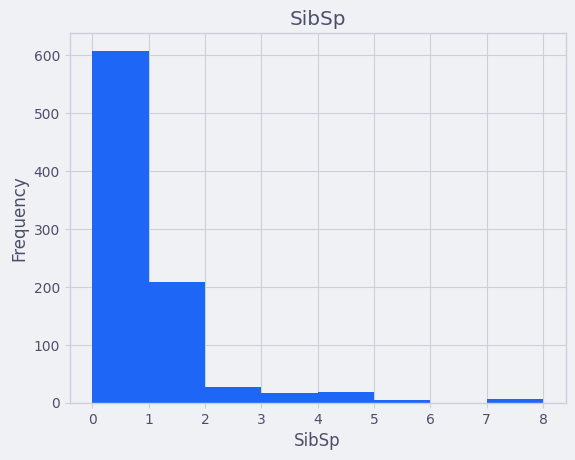

In [9]:
hist ('SibSp', 8)

SibSp is a continuous variable

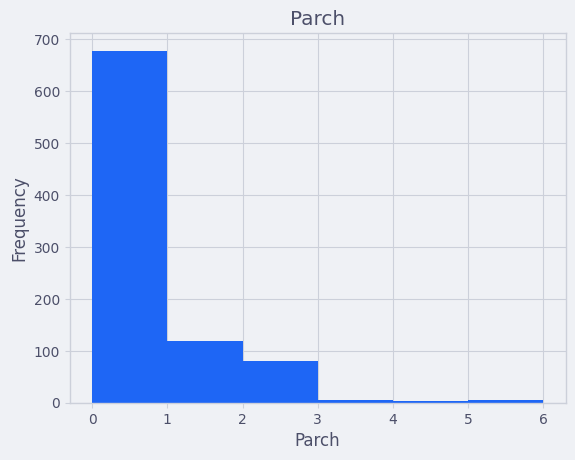

In [10]:
hist ('Parch', 6)

Parch is a continuous variable

In [11]:
train_data["Ticket"].value_counts()

Ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64

The Ticket column is discarded because most of the values are unique values

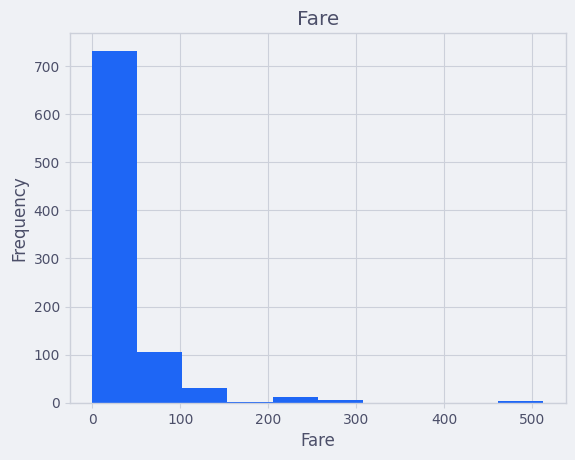

In [12]:
hist ('Fare', 10)

Fare is a continuous variable

In [13]:
train_data["Cabin"].value_counts()

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 147, dtype: int64

The Cabin column is discarded because most of the values are unique values, however, if the values ​​are modified taking only the first letter, it can be observed how it behaves as a categorical variable.

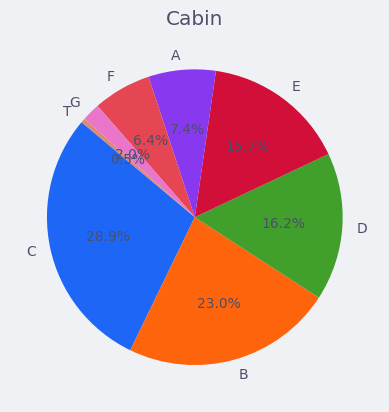

In [14]:
Cabin = train_data['Cabin'].apply(lambda x: x[0] if isinstance(x, str) else x)
category_counts = Cabin.value_counts()
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Cabin')
plt.show()

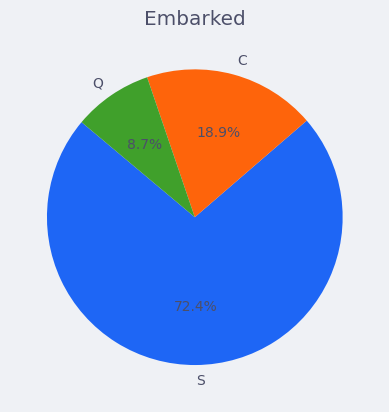

In [15]:
pie('Embarked')

Embarked is a categorical variable

# Preprocessing data

In [6]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

def data_preprocessing (df):
    
    # Modify Cabin column
    df['Cabin'] = train_data['Cabin'].apply(lambda x: x[0] if isinstance(x, str) else x)
    
    # Split the dataframe into categorical and continuous variables
    categorical_cols = ['Pclass', 'Sex', 'Cabin', 'Embarked']
    continuous_cols = ['Age', 'SibSp', 'Parch', 'Fare']

    # Encode categorical features
    encoder = OneHotEncoder(sparse_output=False)
    encoded_data = encoder.fit_transform(df[categorical_cols])
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out())

    # Scale continuous features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[continuous_cols])
    scaled_df = pd.DataFrame(scaled_data, columns=continuous_cols)

    # Combine encoded and scaled data
    final_df = pd.concat([encoded_df, scaled_df], axis=1)
    
    # Fill null values ​​with the column mean
    filled_df = final_df.fillna(final_df.mean())

    return filled_df

In [7]:
y = train_data['Survived']

X = train_data.drop('Survived', axis=1)
X_all = pd.concat([X, test_data], ignore_index=True)
X_all = data_preprocessing (X_all)

X = X_all.iloc[:len(X), :]
X_test = X_all.iloc[len(X):, :]

# Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Initialize the Random Forest classifier
model = RandomForestClassifier()

# Hyperparameter Optimization
parameters = {
    'n_estimators': [10, 20, 50, 100, 200, 500],  # Number of trees in the forest
    'max_features': ['log2', 'sqrt', None], 
    'criterion': ['entropy', 'gini', 'log_loss'],
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10], 
    'bootstrap': [True, False]  # Method for sampling data points
}

# Run the grid search
grid_obj = GridSearchCV(model, parameters, scoring="accuracy")
grid_obj = grid_obj.fit(X, y)

# Set model to the best combination of parameters
model = grid_obj.best_estimator_

# Train the model using the training sets 
model.fit(X, y)

In [19]:
best_params = grid_obj.best_params_
print(best_params)

{'bootstrap': True, 'criterion': 'log_loss', 'max_depth': 7, 'max_features': None, 'n_estimators': 50}


{'bootstrap': True, 'criterion': 'log_loss', 'max_depth': 7, 'max_features': None, 'n_estimators': 50}

Score: 0.77751

# Ada Boost + Grid Search CV

In [22]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

# Initialize the AdaBoost classifier
model = AdaBoostClassifier()

# Hyperparameter Optimization
parameters = {
    'n_estimators': [10, 20, 50, 100, 200, 500],  # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.5, 1.0, 1.5, 2.0],  # Weight applied to each classifier at each boosting iteration
    'algorithm': ['SAMME', 'SAMME.R']  # The algorithm to use: SAMME or SAMME.R
}

# Run the grid search
grid_obj = GridSearchCV(model, parameters, scoring="accuracy")
grid_obj = grid_obj.fit(X, y)

# Set model to the best combination of parameters
model = grid_obj.best_estimator_

# Train the model using the training sets 
model.fit(X, y)

AdaBoostClassifier()

In [25]:
best_params = grid_obj.best_params_
print(best_params)

{'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 50}


{'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 50}

Score: 0.75037

# Bagging + SVC + Grid Search CV

In [22]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV

# Define the base model (SVC)
svc = SVC()

# Wrap the SVC in a BaggingClassifier
model = BaggingClassifier(estimator=svc, n_estimators=10, random_state=42)

param_grid = {
    'estimator__C': [0.1, 1, 10],
    'estimator__kernel': ['linear', 'rbf'], 
    'n_estimators': [5, 10, 20, 30],              
}

# Initialize and fit GridSearchCV
grid_obj = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_obj.fit(X, y)

# Set model to the best combination of parameters
model = grid_obj.best_estimator_

# Train the model using the training sets 
model.fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


BaggingClassifier(estimator=SVC(C=1), n_estimators=20, random_state=42)

In [23]:
best_params = grid_obj.best_params_
print(best_params)

{'estimator__C': 1, 'estimator__kernel': 'rbf', 'n_estimators': 20}


{'estimator__C': 1, 'estimator__kernel': 'rbf', 'n_estimators': 20}

Score: 0.7799

# Bagging + Random Forest + Grid Search CV

In [25]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import GridSearchCV

# Define the base model (RandomForestClassifier)
rf = RandomForestClassifier(random_state=42)

# Wrap the RandomForestClassifier in a BaggingClassifier with fewer estimators
model = BaggingClassifier(estimator=rf, n_estimators=5, random_state=42)

# Set up a reduced parameter grid
param_grid = {
    'estimator__n_estimators': [50, 100],  
    'estimator__max_depth': [None, 10, 20],  
    'estimator__min_samples_split': [2, 5],  
    'n_estimators': [5, 10], 
}

# Initialize and fit GridSearchCV with reduced cv and parameters
grid_obj = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_obj.fit(X, y)

# Set model to the best combination of parameters
model = grid_obj.best_estimator_

# Train the model using the training sets 
model.fit(X, y)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


BaggingClassifier(estimator=RandomForestClassifier(max_depth=10,
                                                   random_state=42),
                  random_state=42)

In [27]:
best_params = grid_obj.best_params_
print(best_params)

{'estimator__max_depth': 10, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 100, 'n_estimators': 10}


{'estimator__max_depth': 10, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 100, 'n_estimators': 10}

Score:  0.77511

# Bagging + Decision Tree

In [44]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier  # Base estimator for Bagging

# Initialize the Bagging classifier with a Decision Tree as the base estimator
model = BaggingClassifier(
    estimator=DecisionTreeClassifier(criterion='log_loss', max_depth=7), 
    n_estimators=50
)

# Train the model using the training sets
model.fit(X, y)

BaggingClassifier(estimator=DecisionTreeClassifier(criterion='log_loss',
                                                   max_depth=7),
                  n_estimators=50)

Score: 0.78229

# Gradient Boosting Classifier

In [9]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the model
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the model
model.fit(X, y)

GradientBoostingClassifier(random_state=42)

Score: 0.77990

# Neural Network

In [28]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers 

# Initialize the model
model = Sequential()

# Add Input layer
model.add(Input(shape=(X.shape[1],)))

# Add first hidden layer with Batch Normalization and L2 regularization
model.add(Dense(units=64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add second hidden layer with Batch Normalization and L2 regularization
model.add(Dense(units=32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add third hidden layer with Batch Normalization and L2 regularization
model.add(Dense(units=16, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add fourth hidden layer with Batch Normalization and L2 regularization
model.add(Dense(units=8, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add output layer
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X, y, epochs=100, batch_size=32, validation_split=0.2, verbose=1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])


Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5117 - loss: 1.1289 - val_accuracy: 0.6816 - val_loss: 0.7772
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5185 - loss: 1.0223 - val_accuracy: 0.6425 - val_loss: 0.7434
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5345 - loss: 1.0180 - val_accuracy: 0.6480 - val_loss: 0.7209
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5867 - loss: 0.9312 - val_accuracy: 0.6536 - val_loss: 0.7041
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5478 - loss: 0.9200 - val_accuracy: 0.6592 - val_loss: 0.6895
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6362 - loss: 0.7869 - val_accuracy: 0.6648 - val_loss: 0.6786
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6109 - loss: 0.8108 - val_accuracy: 0.6760 - val_loss: 0.6673
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6483 - loss: 0.7881 - val_accuracy: 0.6927 - 

Score: 0.78229

# Export data

In [30]:
# Generate predictions (probabilities)
predictions = model.predict(X_test)

# Convert probabilities to binary outcomes (0 or 1)
predictions = (predictions > 0.5).astype(int)

# Flatten the predictions to ensure it's a 1D array
predictions = predictions.flatten()

# Assuming 'test_data' is your original test dataset with 'PassengerId' column
output = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived': predictions})

# Save the output to a CSV file
output.to_csv('submission.csv', index=False)

print("Your submission was successfully saved!")


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Your submission was successfully saved!
